In [3]:
from pysb import *
from pysb.macros import *
from pysb.macros import _macro_rule

import pysb.export as psbexp

from pysb.simulator import ScipyOdeSimulator
import pylab as pl

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def norm(x):
    mm = max([abs(xx) for xx in x])
    if mm == 0: mm = 1
    return [xx/mm for xx in x] 

In [6]:
# RS variables are: p21, pRB, p27Kip1, Myc, CyclinD1, E2F1, CyclinE
#
# p21: Basal transcription + inhibition (phosphorylation) by CyclinE
#
# pRB: when hypophosphorylated, binds to E2F1; can be phosphorylated by CyclinD1 or, if no p27Kip1, by CyclinE
#      (Cyclin binds to pRB, then pRB is phosphorylated, then Cyclin unbinds)
#
# p27Kip1: CyclinD1 binds to p27Kip1 competitively, negating its effect on CyclinE; 
#          CyclinE binding leads to phosphorylation and degradation
#
# Myc: E2F1 binds to promoter for Myc, but pRB prevents this (pRB-E2F1 complex?)
#
# CyclinD1: p21 deactivates by binding; E2F1 binds to promoter for CyclinD1, but pRB prevents this (as in Myc);
#           Myc transciptionally activates CyclinD1; CyclinD1 self activation is assumed without given mechanism
#
# E2F1: pRB binds to E2F1 and switches DNA binding activity from activating to repressing; 
#       E2F1 and Myc transcriptionally activate E2F1
#
# CyclinE: p27Kip1 deactivates by binding; E2F1 binds to promoter for CyclinE, but pRB prevents this (as in Myc);
#
# Boolean rules (suggestively written):
# p21 *= ~CyclinE
# pRB *= ~CyclinD1 & (p27Kip1 | ~CyclinE) (active form is ~pRB *= CyclinD1 | (~p27Kip1 & CyclinE) )
# p27Kip1 *= ~CyclinE & ~CyclinD1
# Myc *= ~pRB & E2F1
# CyclinD1 *= ~p21 & (Myc | E2F1) | (Myc | CyclinD1) & (~pRB & E2F1)
# E2F1 *= ~pRB & ((~pRB & E2F1) | Myc)
# CyclinE *= (~pRB & E2F1) & ~p27Kip1
#

Model()

# Proteins
Monomer('P_pRB',['bind_E2F1','bind_CycED','state'],{'state':['p','u']})
Monomer('P_CyclinD1',['bind_pRB','bind_p27Kip1','bind_p21'])
Monomer('P_E2F1',['bind_DNA','bind_pRB'])
Monomer('P_p21',['bind_CycD','bind_CycE','state'],{'state':['p','u']})
Monomer('P_CyclinE',['bind_pRB','bind_p27Kip1','bind_p21'])
Monomer('P_Myc',['bind_DNA'])
Monomer('P_p27Kip1',['bind_CycED','state'],{'state':['p','u']})

# Genes (ommit mRNA; just have genes -> proteins)
# Monomer('g_pRB') # assume constant total protein (no transcription)
Monomer('g_CyclinD1',['bind_E2F1','bind_Myc'])
Monomer('g_CyclinE',['bind_E2F1'])
Monomer('g_E2F1',['bind_E2F1','bind_Myc'])
Monomer('g_Myc',['bind_E2F1'])

# Parameters
Parameter('kbasal',1)
Parameter('kdeg',1)
Parameter('ktrans',1)
Parameter('ktransH',2)
Parameter('kbindPP',1)
Parameter('kunbindPP',0.05)
Parameter('kbindPG',1e3)
Parameter('kunbindPG',5e2)
Parameter('kcat',1e4)
Parameter('kdephos',1e-2)
Parameter('kfast',50)
Parameter('kslow',1e-2)
Parameter('kmid',1e-1)

# Model Outputs
Observable('pRB',P_pRB(bind_E2F1=WILD,bind_CycED=None,state='u'))
Observable('pRBp',P_pRB(bind_E2F1=WILD,bind_CycED=None,state='p'))
Observable('CyclinD1',P_CyclinD1(bind_pRB=None,bind_p21=None,bind_p27Kip1=None))
Observable('CyclinE',P_CyclinE(bind_p27Kip1=None,bind_pRB=None,bind_p21=None))
Observable('E2F1',P_E2F1(bind_DNA=WILD,bind_pRB=None))
Observable('E2F1F',P_E2F1(bind_DNA=None,bind_pRB=None))
Observable('p21',P_p21(bind_CycD=None,bind_CycE=None,state='u'))
Observable('Myc',P_Myc(bind_DNA=None))
Observable('p27Kip1',P_p27Kip1(bind_CycED=None,state='u'))


# Intervention Reactions
Monomer('__t')
Parameter('time_rate',1.0)
Rule('track_time___t', None >> __t(), time_rate)
Observable('t',__t())

Parameter('t_add_pRB_on',100000)
Parameter('t_add_pRB_off',150000)
Parameter('t_rem_pRB_on',300000)
Parameter('t_rem_pRB_off',350000)
Parameter('t_add_Myc_on',300000)
Parameter('t_add_Myc_off',350000)
Expression('add_pRB_rate', 1*(t_add_pRB_on <= t)*(t <= t_add_pRB_off) )
Expression('rem_pRB_rate', 1*(t_rem_pRB_on <= t)*(t <= t_rem_pRB_off) )
Expression('add_Myc_rate', 0.2*(t_add_Myc_on <= t)*(t <= t_add_Myc_off) )

Rule('add_pRB', None >> P_pRB(bind_E2F1=None,bind_CycED=None,state='u'),add_pRB_rate)
Rule('rem_pRB', P_pRB(bind_E2F1=None,bind_CycED=None,state='u') >> None,rem_pRB_rate)
Rule('add_Myc', None >> P_Myc(bind_DNA=None),add_Myc_rate)

# Unspecified Mechanism (assume Hill kinetics)
Expression('cycD_auto_rate', 0.25 + 1.5*(CyclinD1**4 / (CyclinD1**4 + 1/16)) )

# Protein-Protein Interaction
catalyze(P_CyclinD1, 'bind_pRB', P_pRB(state='u'), 'bind_CycED', P_pRB(state='p'), [kbindPP,kunbindPP,kcat])
catalyze(P_CyclinE(bind_p27Kip1=None), 'bind_pRB', P_pRB(state='u'), 'bind_CycED', P_pRB(state='p'), [kbindPP,kunbindPP,kcat])
catalyze(P_CyclinE(bind_p27Kip1=None), 'bind_p21', P_p21(state='u',bind_CycD=None), 'bind_CycE', P_p21(state='p',bind_CycD=None), [kbindPP,kunbindPP,kcat])
catalyze(P_CyclinE(bind_pRB=None), 'bind_p27Kip1', P_p27Kip1(state='u'), 'bind_CycED', P_p27Kip1(state='p'), [kfast,kunbindPP,kcat])
bind(P_pRB(state='u'), 'bind_E2F1', P_E2F1, 'bind_pRB', [kbindPP,kunbindPP])
Rule('dephosRB',P_pRB(state='p') >> P_pRB(state='u'),kdephos)
Rule('dephos21',P_p21(state='p') >> P_p21(state='u'),kdephos)
bind(P_p21(state='u',bind_CycE=None), 'bind_CycD', P_CyclinD1, 'bind_p21', [kbindPP,kunbindPP])

# Protein-DNA binding
bind(P_E2F1(bind_pRB=None), 'bind_DNA', g_CyclinD1, 'bind_E2F1', [kbindPG,kunbindPG])
bind(P_Myc, 'bind_DNA', g_CyclinD1, 'bind_Myc', [kbindPG,kunbindPG])
bind_complex( P_E2F1(bind_DNA=1,bind_pRB=None) % g_CyclinD1(bind_E2F1=1), 'bind_Myc', P_Myc, 'bind_DNA', [kbindPG,kunbindPG] )
bind_complex( P_Myc(bind_DNA=1) % g_CyclinD1(bind_Myc=1), 'bind_E2F1', P_E2F1(bind_pRB=None), 'bind_DNA', [kbindPG,kunbindPG] )

bind(P_E2F1(bind_pRB=None), 'bind_DNA', g_CyclinE, 'bind_E2F1', [kbindPG,kunbindPG])

bind(P_E2F1(bind_pRB=None), 'bind_DNA', g_E2F1, 'bind_E2F1', [kbindPG,kunbindPG])
bind(P_Myc, 'bind_DNA', g_E2F1, 'bind_Myc', [kbindPG,kunbindPG])
bind_complex( P_E2F1(bind_DNA=1,bind_pRB=None) % g_E2F1(bind_E2F1=1), 'bind_Myc', P_Myc, 'bind_DNA', [kbindPG,kunbindPG] )
bind_complex( P_Myc(bind_DNA=1) % g_E2F1(bind_Myc=1), 'bind_E2F1', P_E2F1(bind_pRB=None), 'bind_DNA', [kbindPG,kunbindPG] )

Rule('Myc_TFA', P_E2F1(bind_pRB=None,bind_DNA=None)+P_E2F1(bind_pRB=None,bind_DNA=None)+P_E2F1(bind_pRB=None,bind_DNA=None)+P_E2F1(bind_pRB=None,bind_DNA=None) + g_Myc(bind_E2F1=None) | P_E2F1(bind_pRB=None,bind_DNA=1) % g_Myc(bind_E2F1=1),kbindPG,kunbindPG)

#bind(P_E2F1(bind_pRB=None), 'bind_DNA', g_Myc(bind_E2F1_b=None), 'bind_E2F1_a', [kbindPG,kunbindPG])
#bind(P_E2F1(bind_pRB=None), 'bind_DNA', g_Myc(bind_E2F1_a=None), 'bind_E2F1_b', [kbindPG,kunbindPG])
#bind_complex(P_E2F1(bind_pRB=None), 'bind_DNA', P_E2F1(bind_pRB=None, bind_DNA=ANY) % g_Myc(bind_E2F1_b=ANY,bind_E2F1_a=None), 'bind_E2F1_a', [kbindPG,kunbindPG])
#bind_complex(P_E2F1(bind_pRB=None), 'bind_DNA', P_E2F1(bind_pRB=None, bind_DNA=ANY) % g_Myc(bind_E2F1_b=None,bind_E2F1_a=ANY), 'bind_E2F1_b', [kbindPG,kunbindPG])

def transcribe(gene_complex, protein,kt):
    return _macro_rule('transcribe', gene_complex >> gene_complex + protein, [kt], ['kt'])

# Transcription / Synthesis
transcribe(P_E2F1(bind_DNA=1,bind_pRB=None) % g_CyclinD1(bind_E2F1=1), P_CyclinD1(bind_p27Kip1=None,bind_pRB=None,bind_p21=None), cycD_auto_rate)
transcribe(P_Myc(bind_DNA=1) % g_CyclinD1(bind_Myc=1), P_CyclinD1(bind_p27Kip1=None,bind_pRB=None,bind_p21=None), cycD_auto_rate)
transcribe(P_E2F1(bind_DNA=1,bind_pRB=None) % P_Myc(bind_DNA=10) % g_CyclinD1(bind_E2F1=1, bind_Myc=10), P_CyclinD1(bind_p27Kip1=None,bind_pRB=None,bind_p21=None), cycD_auto_rate)

transcribe(P_E2F1(bind_DNA=1,bind_pRB=None) % g_CyclinE(bind_E2F1=1), P_CyclinE(bind_p27Kip1=None,bind_pRB=None,bind_p21=None), ktransH)

transcribe(P_Myc(bind_DNA=1) % g_E2F1(bind_Myc=1), P_E2F1(bind_pRB=None,bind_DNA=None), ktrans)
transcribe(P_E2F1(bind_DNA=1) % g_E2F1(bind_E2F1=1), P_E2F1(bind_pRB=None,bind_DNA=None), ktrans)
transcribe(P_Myc(bind_DNA=1) % P_E2F1(bind_DNA=10) % g_E2F1(bind_Myc=1,bind_E2F1=10), P_E2F1(bind_pRB=None,bind_DNA=None), ktransH)

transcribe(P_E2F1(bind_DNA=1) % g_Myc(bind_E2F1=1), P_Myc(bind_DNA=None), ktrans)

synthesize(P_p21(bind_CycD=None,bind_CycE=None,state='u'), kbasal)
synthesize(P_p27Kip1(bind_CycED=None,state='u'), kbasal)

# Degradation
degrade(P_CyclinD1(bind_pRB=None,bind_p21=None,bind_p27Kip1=None),kdeg)
degrade(P_CyclinE(bind_pRB=None,bind_p21=None,bind_p27Kip1=None),kdeg)

degrade(P_p27Kip1(bind_CycED=None,state='p'),kfast)
degrade(P_p27Kip1(bind_CycED=None,state='u'),kdeg)
degrade(P_p27Kip1(bind_CycED=ANY) % P_CyclinE(bind_p27Kip1=ANY),kfast)

degrade(P_E2F1(bind_DNA=None,bind_pRB=None),kdeg)
Rule('extraDeg',P_E2F1(bind_DNA=None,bind_pRB=ANY) % P_pRB(bind_E2F1=ANY) >> P_pRB(bind_E2F1=None,bind_CycED=None,state='u'),kdeg)

degrade(P_p21(bind_CycD=None,state='u'), kdeg)
degrade(P_p21(bind_CycD=None,state='p'),kfast)

degrade(P_Myc(bind_DNA=None),2.0)

# Initial Conditions (fixed)
pRB_Total = 1

Parameter('g0',1)
Initial(g_CyclinD1(bind_E2F1=None,bind_Myc=None),g0)
Initial(g_CyclinE(bind_E2F1=None),g0)
Initial(g_E2F1(bind_E2F1=None,bind_Myc=None),g0)
Initial(g_Myc(bind_E2F1=None),g0)

# Initial Conditions (variable)
vpRB_u0 = 1.0
Parameter('pRB_u0',vpRB_u0)
Parameter('pRB_p0',pRB_Total - vpRB_u0)
Initial(P_pRB(bind_E2F1=None,bind_CycED=None,state='u'),pRB_u0)
Initial(P_pRB(bind_E2F1=None,bind_CycED=None,state='p'),pRB_p0)

Parameter('p21_0',1)
Initial(P_p21(bind_CycD=None,bind_CycE=None,state='u'), p21_0)

Parameter('CyclinD1_0',0)
Initial(P_CyclinD1(bind_p27Kip1=None,bind_pRB=None,bind_p21=None), CyclinD1_0)

Parameter('CyclinE_0',0)
Initial(P_CyclinE(bind_p27Kip1=None,bind_pRB=None,bind_p21=None), CyclinE_0)

Parameter('E2F1_0',0)
Initial(P_E2F1(bind_DNA=None,bind_pRB=None),E2F1_0)

Parameter('Myc_0',0)
Initial(P_Myc(bind_DNA=None),Myc_0)

Parameter('p27Kip1_0',1)
Initial(P_p27Kip1(bind_CycED=None,state='u'),p27Kip1_0)


Initial(P_p27Kip1(bind_CycED=None, state='u'), p27Kip1_0)

In [15]:
# Define the simulation time and resolution, then generate the internal model code
t = pl.linspace(0, 500000, num=402)
sim = ScipyOdeSimulator(model, tspan=t)

In [11]:
# Specify initial conditions
I2 = {P_CyclinD1(bind_pRB=None,bind_p21=None,bind_p27Kip1=None):2,
      P_CyclinE(bind_pRB=None,bind_p21=None,bind_p27Kip1=None):0.6,
      P_E2F1(bind_pRB=None,bind_DNA=None):4,
      P_pRB(bind_E2F1=None,bind_CycED=None,state='u'):1,
      P_pRB(bind_E2F1=None,bind_CycED=None,state='p'):1,
      P_p21(bind_CycD=None,bind_CycE=None,state='u'):0.4,
      P_p27Kip1(bind_CycED=None,state='u'):0,
      P_Myc(bind_DNA=None):0.5
     }

In [16]:
# Run the simulation for the given initial conditions
simres = sim.run(initials = I2)
yout = simres.all

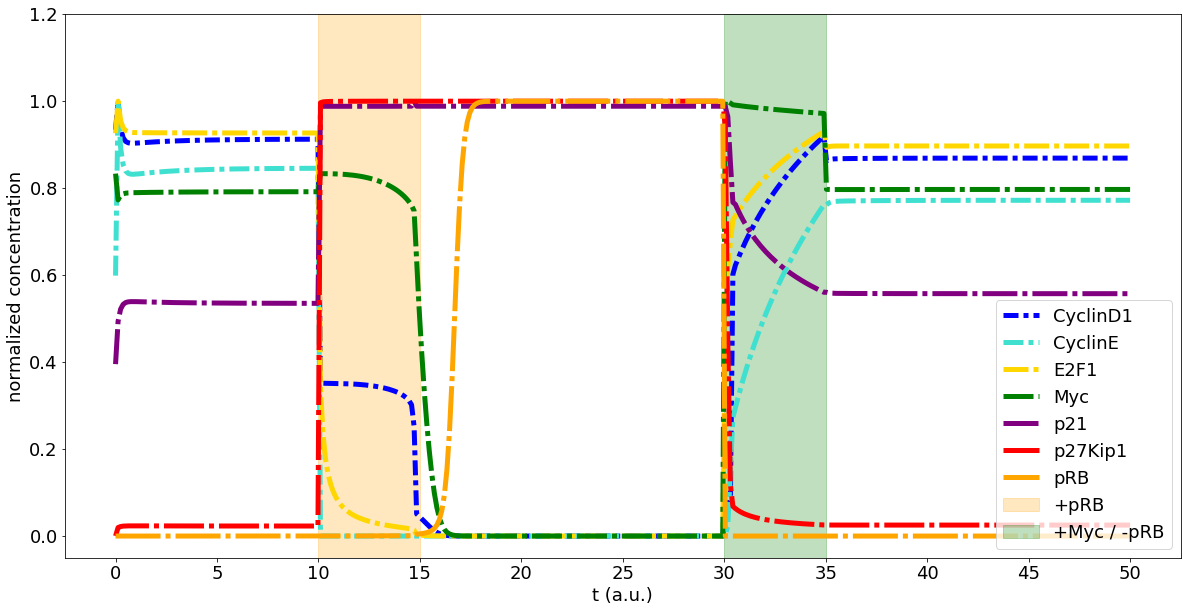

In [17]:
# Plot the simulation results
matplotlib.rcParams.update({'font.size': 18})
tp = t/10000.0
gp = plt.figure(figsize=(20,10))
vsort = ['CyclinD1','CyclinE','E2F1','Myc','p21','p27Kip1','pRB']
colors = ['blue','turquoise','gold','green','purple','red','orange']
#          cycD   cycE        E2F1    Myc     p21       p27     pRB
for i in range(len(vsort)):
    plt.plot(tp,norm(yout[vsort[i]]),label=vsort[i],dashes=[3+i,1,1,1],linewidth=5,color=colors[i])

plt.axvspan(10, 15, alpha=0.25, color='orange',label='+pRB')
plt.axvspan(30, 35, alpha=0.25, color='green',label='+Myc / -pRB')
plt.legend(loc='lower right')
plt.ylabel('normalized concentration')
plt.xlabel('t (a.u.)')
plt.yticks([0.2*i for i in range(7)])
plt.xticks([5*i for i in range(11)])
plt.savefig('CRS.png')
plt.show()

In [18]:
# Export the simulation in a SageMath-readable format
import numpy as np
vsort = ['CyclinD1','CyclinE','E2F1','Myc','p21','p27Kip1','pRB']
youtc = []
for vv in vsort:
    youtc.append( list(yout[vv]) )

np.save('./yout_Myc_pRB.npy',youtc)